# ==========================================
# AE3 - Exercicio 2 letra B- Deslocamentos
# 1) Importando bibliotecas pytorch
# ==========================================

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===========================================================
# 2) Constantes, domínio e solução analítica (para checagem)
# ===========================================================

In [2]:
# ---------------- Parâmetros do problema (SI) ----------------
L  = 6.0                      # m
I  = 22500e-8                 # m^4
E  = 21000e7                  # Pa
q  = 2e3                      # N/m
EI = E*I

# ----------- Solução analítica (Beer & Johnston) ------------
def w_analit(x):
    x = np.asarray(x)
    return (q/(24*EI)) * ( x*(L**3 - 2*L*x**2 + x**3) )

def theta_analit(x):
    x = np.asarray(x)
    return (q/(24*EI)) * ( L**3 - 6*L*x**2 + 4*x**3 )

x_plot = np.linspace(0, L, 200)[:, None]
w_max_analit = 5*q*L**4/(384*EI)       # em x=L/2
theta_apoio  = q*L**3/(24*EI)          # |theta| nos apoios

print(f"[Analítico] w_max = {w_max_analit*1e3:.3f} mm | |theta|_apoio = {theta_apoio:.6f} rad ({np.degrees(theta_apoio):.3f} deg)")

# --------------------- HIPERPARÂMETROS ----------------------
HIDDEN_LAYERS   = 4
NEURONS_PER_LAY = 50
ACTIVATION_NAME = "tanh"       # 'tanh' | 'relu' | 'silu'
Nf  = 200                      # pontos internos (colocação)
Nb0 = 16                       # pontos em x=0 (reforçado)
NbL = 16                       # pontos em x=L (reforçado)
LR = 1e-3                      # taxa de aprendizagem (Adam)
EPOCHS = 8000                  # épocas (Adam)
USE_LBFGS = True               # refino com L-BFGS

# pesos de loss (reforçam momentos nulos nos apoios)
LAMBDA_PDE = 1.0
LAMBDA_M0  = 10.0              # w''(0)=0
LAMBDA_ML  = 10.0              # w''(L)=0

# escala típica de deflexão (normalização da saída)
w_scale = float(w_max_analit)

print("[Config PINN corrigida]")
print(f"  - Rede: {HIDDEN_LAYERS} camadas × {NEURONS_PER_LAY} neurônios (ativação: {ACTIVATION_NAME})")
print(f"  - Pontos: Nf={Nf}, Nb0={Nb0}, NbL={NbL}")
print(f"  - Otimizadores: Adam(lr={LR}){' + L-BFGS' if USE_LBFGS else ''}; Épocas(Adam)={EPOCHS}")
print(f"  - Pesos de perda: PDE={LAMBDA_PDE}, w''(0)={LAMBDA_M0}, w''(L)={LAMBDA_ML}")


[Analítico] w_max = 0.714 mm | |theta|_apoio = 0.000381 rad (0.022 deg)
[Config PINN corrigida]
  - Rede: 4 camadas × 50 neurônios (ativação: tanh)
  - Pontos: Nf=200, Nb0=16, NbL=16
  - Otimizadores: Adam(lr=0.001) + L-BFGS; Épocas(Adam)=8000
  - Pesos de perda: PDE=1.0, w''(0)=10.0, w''(L)=10.0


# =================================
# 3) Definição da PINN (PDE e C.C.)
# =================================

In [3]:
# --------- helpers de derivada ---------
def grad(y, x):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True
    )[0]

def safe_grad(y, x):
    g = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True, allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def make_activation(name):
    name = name.lower()
    if name == "tanh": return nn.Tanh()
    if name == "relu": return nn.ReLU()
    if name == "silu": return nn.SiLU()
    raise ValueError("ACTIVATION_NAME deve ser 'tanh', 'relu' ou 'silu'.")

# --------- MLP + parametrização "hard" para w(0)=w(L)=0 ---------
# w(x) = w_scale * x*(L-x) * f(ξ),  ξ = x/L
class FCN(nn.Module):
    def __init__(self, hidden_layers, neurons, act_name):
        super().__init__()
        act = make_activation(act_name)
        layers = [nn.Linear(1, neurons), act]
        for _ in range(hidden_layers-1):
            layers += [nn.Linear(neurons, neurons), act]
        layers += [nn.Linear(neurons, 1)]
        self.net = nn.Sequential(*layers)
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.act_name = act_name
    def forward(self, x):
        xi = x / L
        f  = self.net(xi)
        return w_scale * (x*(L - x)) * f    # impõe w(0)=w(L)=0 exatamente

net = FCN(HIDDEN_LAYERS, NEURONS_PER_LAY, ACTIVATION_NAME).to(device)

# resumo
def count_params(m): return sum(p.numel() for p in m.parameters())
print("[Resumo da Rede]")
print(f"  - Arquitetura: [1] + {[NEURONS_PER_LAY]*HIDDEN_LAYERS} + [1] | #Parâmetros: {count_params(net):,}")

# --------- pontos como LEAF (evita erro de backward) ---------
def leaf(t): return t.detach().requires_grad_(True)

x_f = leaf(torch.rand(Nf, 1, device=device) * L)      # (0,L)
x0  = leaf(torch.zeros(Nb0, 1, device=device))        # 0
xL  = leaf(torch.full((NbL, 1), L, device=device))    # L  (sem multiplicar por L)


[Resumo da Rede]
  - Arquitetura: [1] + [50, 50, 50, 50] + [1] | #Parâmetros: 7,801


# 4) Treino (Adam + L-BFGS) e pós-processamento

In [4]:
mse = nn.MSELoss()

def physics_residual(x):
    w = net(x)
    w_x   = grad(w, x)
    w_xx  = grad(w_x, x)
    w_xxx = grad(w_xx, x)
    w_xxxx= grad(w_xxx, x)
    return w_xxxx - q/EI             # PDE: w'''' = q/EI

def loss_func():
    # PDE
    r_f = physics_residual(x_f)
    loss_pde = LAMBDA_PDE * mse(r_f, torch.zeros_like(r_f))
    # CC de momento nulo (w''=0) nos apoios
    w0    = net(x0)
    w0_x  = grad(w0, x0);  w0_xx = grad(w0_x, x0)
    wL    = net(xL)
    wL_x  = grad(wL, xL);  wL_xx = grad(wL_x, xL)
    loss_M0 = LAMBDA_M0 * mse(w0_xx, torch.zeros_like(w0_xx))
    loss_ML = LAMBDA_ML * mse(wL_xx, torch.zeros_like(wL_xx))
    loss = loss_pde + loss_M0 + loss_ML
    return loss, (loss_pde.item(), loss_M0.item(), loss_ML.item())

# --------- Adam (com reamostragem de x_f) ---------
opt = torch.optim.Adam(net.parameters(), lr=LR)
loss_hist = []
print("[Treino] Adam")
for epoch in range(EPOCHS):
    if (epoch % 200) == 0:              # reamostra domínio periodicamente
        x_f = leaf(torch.rand(Nf, 1, device=device) * L)
    opt.zero_grad()
    loss, parts = loss_func()
    loss.backward()
    opt.step()
    loss_hist.append(loss.item())
    if (epoch+1) % 1000 == 0:
        p = tuple(f"{v:.1e}" for v in parts)
        print(f"  epoch {epoch+1:5d}: loss={loss.item():.3e}  parts={p}")

# --------- L-BFGS (refino) ---------
if USE_LBFGS:
    print("[Treino] L-BFGS (refino)")
    optimizer = torch.optim.LBFGS(net.parameters(), lr=1.0, max_iter=500,
                                   history_size=50, line_search_fn="strong_wolfe")
    def closure():
        optimizer.zero_grad()
        l, _ = loss_func()
        l.backward()
        return l
    lbfgs_loss = optimizer.step(closure).item()
    print(f"  LBFGS final loss: {lbfgs_loss:.3e}")

# --------- Pós-processamento ---------
with torch.no_grad():
    x_plot_t = torch.tensor(x_plot, dtype=torch.float32, device=device)
    w_pred = net(x_plot_t).cpu().numpy().squeeze(-1)

# w_max em x=L/2
x_mid = torch.tensor([[L/2]], dtype=torch.float32, device=device, requires_grad=True)
w_mid = net(x_mid).detach().cpu().squeeze().item()

# |theta| no apoio (x=0)
x0_ind = torch.tensor([[0.0]], dtype=torch.float32, device=device, requires_grad=True)
theta_0_t = safe_grad(net(x0_ind), x0_ind)
theta_0 = abs(theta_0_t.detach().cpu().squeeze().item())

# métricas vs analítico
w_err  = abs(w_mid - w_max_analit)/abs(w_max_analit)
th_err = abs(theta_0 - theta_apoio)/abs(theta_apoio)

print("\n[Resumo dos Resultados]")
print(f"  w_max (PINN)  = {w_mid:.6e} m  ({1e3*w_mid:.3f} mm)   |  erro rel. = {100*w_err:.3f}%")
print(f"  |theta|(apoio) PINN = {theta_0:.6f} rad ({np.degrees(theta_0):.3f} deg) |  erro rel. = {100*th_err:.3f}%")


[Treino] Adam
  epoch  1000: loss=5.229e-10  parts=('5.2e-10', '1.5e-15', '3.1e-14')
  epoch  2000: loss=1.712e-10  parts=('1.7e-10', '2.8e-16', '4.0e-15')
  epoch  3000: loss=7.586e-11  parts=('7.6e-11', '5.3e-17', '1.1e-15')
  epoch  4000: loss=3.039e-11  parts=('3.0e-11', '7.4e-17', '5.0e-16')
  epoch  5000: loss=1.130e-11  parts=('1.1e-11', '1.7e-17', '9.9e-17')
  epoch  6000: loss=5.864e-12  parts=('5.9e-12', '2.8e-18', '1.5e-18')
  epoch  7000: loss=5.980e-12  parts=('6.0e-12', '9.1e-18', '3.8e-18')
  epoch  8000: loss=5.291e-12  parts=('5.3e-12', '7.6e-19', '3.3e-17')
[Treino] L-BFGS (refino)
  LBFGS final loss: 5.291e-12

[Resumo dos Resultados]
  w_max (PINN)  = 7.169067e-04 m  (0.717 mm)   |  erro rel. = 0.367%
  |theta|(apoio) PINN = 0.000382 rad (0.022 deg) |  erro rel. = 0.319%


# 5) Gráficos (comparação e função de perda)

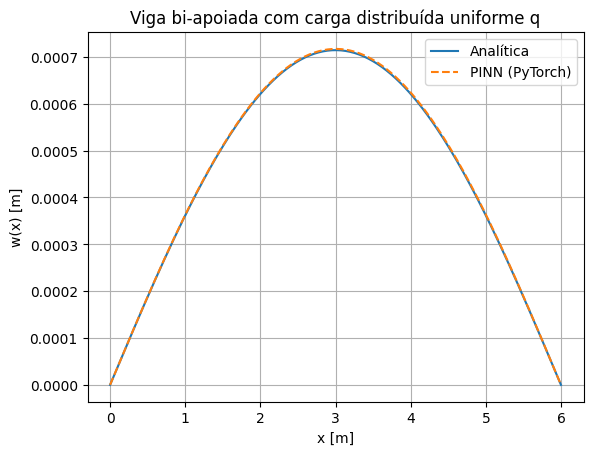

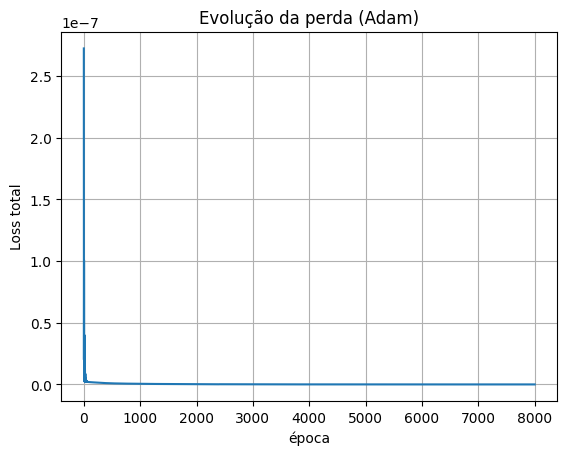

In [5]:
# deslocamento
plt.figure()
plt.plot(x_plot, w_analit(x_plot), label="Analítica")
plt.plot(x_plot, w_pred, "--", label="PINN (PyTorch)")
plt.xlabel("x [m]"); plt.ylabel("w(x) [m]")
plt.title("Viga bi-apoiada com carga distribuída uniforme q")
plt.grid(True); plt.legend(); plt.show()

# perda (Adam)
plt.figure()
plt.plot(loss_hist)
plt.xlabel("época"); plt.ylabel("Loss total")
plt.title("Evolução da perda (Adam)")
plt.grid(True); plt.show()